In [1]:
import pandas as pd
import plotly.express as px


In [2]:
df = pd.read_json("data/exp3.json")
df[['role', 'type']].groupby(by=['role']).count().reset_index()


,role,type
0,,1
1,cooperator,12942
2,cooperatorfood,1
3,home,1


In [3]:
def clean(df):
    ids = df[['id', 'type']].groupby(by=['id']).count().reset_index()
    ids = ids[ids['type'] > 20]['id'].to_list()

    steps = df[['step', 'type']].groupby(by=['step']).count().reset_index()
    steps = steps[steps['type'] > 1]['step'].to_list()

    df = df[df['id'].isin(ids) & df['step'].isin(steps)]

    df['id'] = pd.to_numeric(df['id'], errors='coerce')
    df['step'] = pd.to_numeric(df['step'], errors='coerce')
    df['X'] = pd.to_numeric(df['X'], errors='coerce')
    df['Y'] = pd.to_numeric(df['Y'], errors='coerce')

    df.dropna()
    return df

In [4]:
def acc_score(df):
    df['d_goal'] = ((df['X'] - (-4))**2 + (df['Y'] - 4)**2)**(1/2)
    count: pd.DataFrame = df[df['d_goal'] < 0.3].groupby(by=['id', 'last_poi_timestamp']).min().reset_index()[['step']].groupby(by=['step'])['step'].count()#.rename(columns={'step': "count"}).reset_index()
    step_goal = list(map(lambda x: [int(x[0]), x[1]], sorted(count.to_dict().items(), key=lambda x: x[0])))

    step_list = []
    acc_list = []
    acc = 0
    for v in step_goal:
        acc += v[1] / (df['id'].max() + 1)
        step_list.append(v[0])
        acc_list.append(acc)

    return step_list, acc_list

In [14]:
df_1 = pd.read_json("data/exp3.json")
df_2 = pd.read_json("data/exp7.json")
df_3 = pd.read_json("data/exp8.json")
#df_4 = pd.read_json("data/exp4.json")

df_1 = clean(df_1)
df_2 = clean(df_2)
df_3 = clean(df_3)
#df_4 = clean(df_4)

score_1 = acc_score(df_1)
score_2 = acc_score(df_2)
score_3 = acc_score(df_3)
#score_4 = acc_score(df_4)

/tmp/ipykernel_469876/597504299.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_469876/597504299.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_469876/597504299.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

In [12]:
var = 'pourcentage of detractor (%)'
df_1 = pd.DataFrame.from_dict({'step': score_1[0], 'cumulative food by robot at step': score_1[1]}, orient="columns")
df_1[var] = 0

df_2 = pd.DataFrame.from_dict({'step': score_2[0], 'cumulative food by robot at step': score_2[1]}, orient="columns")
df_2[var] = 10

df_3 = pd.DataFrame.from_dict({'step': score_3[0], 'cumulative food by robot at step': score_3[1]}, orient="columns")
df_3[var] = 40

#df_4 = pd.DataFrame.from_dict({'step': score_4[0], 'cumulative food by robot at step': score_4[1]}, orient="columns")
#df_4['number of robots'] = 20

graph_df = pd.concat([df_1, df_2, df_3])
#graph_df = pd.concat([df_1, df_2, df_3, df_4])

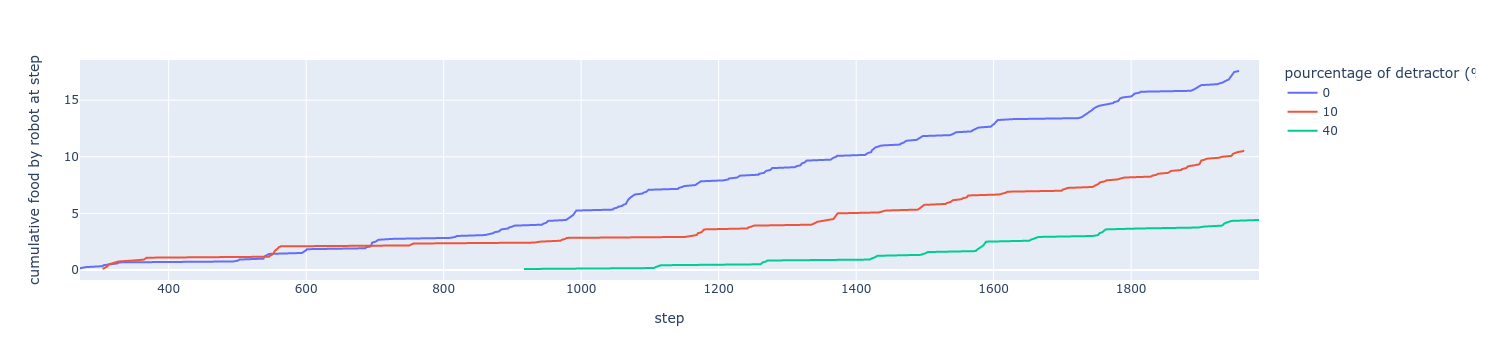

In [13]:
px.line(graph_df, x='step', y='cumulative food by robot at step', color=var)

In [15]:
df = df_3[df_3['step'] > 1500]

In [17]:

print(df['step'].max(), df['id'].max())
for i in range(df['id'].max() + 1):
    print(i)
    seen = False
    for j in range(int(df['step'].max()) + 1):
        data = df[(df['id'] == i) & (df['step'] == j)]
        seen = data.shape[0] == 1 or seen

        if seen and data.shape[0] == 0:
            row = df[(df['id'] == i) & (df['step'] == (j - 1))].copy()
            row['step'] = j
            df = pd.concat([df, row], ignore_index=True)

1999.0 11
0
1
2
3
4
5
6
7
8
9
10
11


In [25]:
df_dots = pd.DataFrame(data=[{'x': 0, 'y': 0, 'c': 'Home', 's': 8}, {'x': -4, 'y': 4, 'c': 'Food', 's': 5}])
fig_center = px.scatter(df_dots, x="x", y="y", color="c", symbol='c', size='s', color_discrete_sequence=['#0F0', '#0FF'])

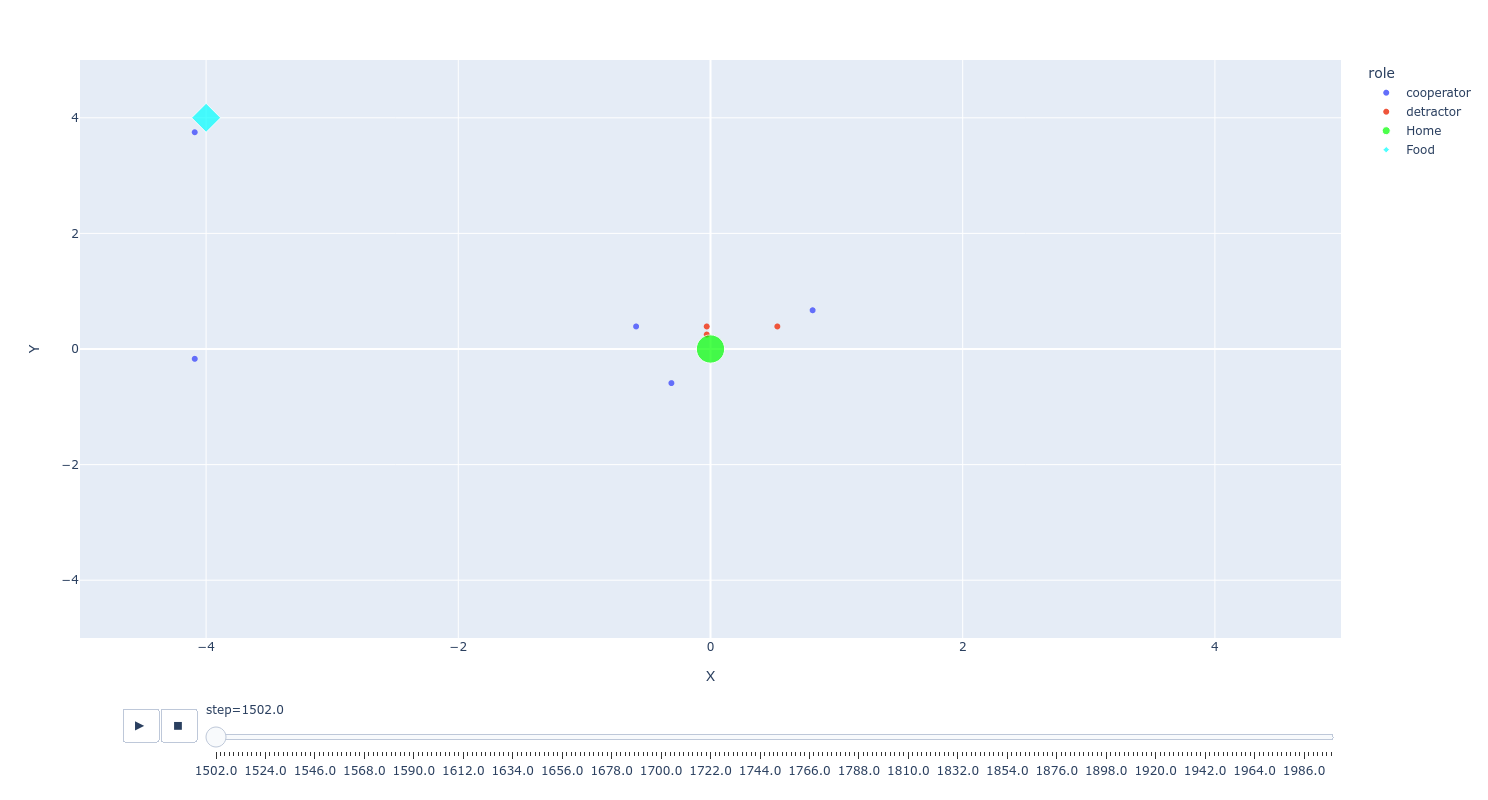

In [27]:
fig = px.scatter(df[(df['step'] % 2) == 0], x="X", y="Y", color="role", animation_frame="step", animation_group="id", width=1000, height=800, range_x=[-5,5], range_y=[-5,5])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2
fig.add_traces(fig_center['data'])
fig